In [1]:
'''
Read and import data
'''

from google.colab import files
import os
import re
import pandas as pd
from io import StringIO

class MSD_Load:
  def UploadMSDFiles():
    uploaded = files.upload()

  def FilePaths(ParentPath):
    Paths = []
    with os.scandir(ParentPath) as entries:
        for entry in entries:
          if entry.name.endswith('.arff'):
            Paths.append(ParentPath + entry.name)
    return Paths
  
  def ExtractDat(Paths):
    FinalData = ''
    CUIDic = {}
    for entry in Paths:
      match = re.search(r'/content/(.*)_pmids_tagged.arff',entry).group(1)
      with open(entry, 'r', encoding = "ISO-8859-1") as f:
        data = f.read()
        
        # Extract CUI, attributes, and data
        CUIData = re.search(r'@RELATION (.*)\n', data).group(1).split('_')
        Attributes = re.findall(r'@ATTRIBUTE (.*)\n', data)
        FullData = re.search(r'@DATA\n(.*)', data, re.DOTALL).group(1)

        # Match CUI and M#s
        Classes = [i for i in Attributes if 'class' in i]
        Index = Attributes.index(Classes[0])
        MVals = re.search(r'class {(.*)}', Classes[0])
        MValsList = MVals.group(1).split(', ')

        # Replace M#s with correct CUIs in FullData
        c = 0
        for CUI in CUIData:
          FullData = FullData.replace(MValsList[c] + '\n',CUI + '\n')
          c += 1

        # Insert ambiguous at the start of all lines
        FullData = FullData.split('\n')
        del FullData[-1]
        c = 0
        for line in FullData:
          FullData[c] = match + ',' + line
          c += 1
        FullData = '\n'.join(FullData)

        # Append to data list
        FinalData += FullData + '\n'

        CUIDic[match] = CUIData

        f.close()

    # Join data
    Attributes[Index] = 'CUI'
    AttributesStr = 'ambiguous word,' + ",".join(Attributes) + '\n'
    FinalData = AttributesStr + FinalData
    return FinalData, CUIDic

  def String2DF(String):
    # Just use splits
    String = String.split('\n')

    # Change relevant commas to tabs
    FinalString = ''
    c = 0
    for element in String:
      ElementList = element.split('"')
      if len(ElementList)-3 != 0:
        FinalString += ElementList[0].replace(',', '\t') + '\n'
      else:
        ElementList[0] = ElementList[0].replace(',', '\t')
        ElementList[2] = ElementList[2].replace(',', '\t')
        FinalString += '"'.join(ElementList) + '\n'
      c += 1

    # Convert tab seperated values to a df
    df = pd.read_csv(StringIO(FinalString), sep = '\t')
    return df
  
  # # df.to_csv('MSDFile.tsv',sep='\t',encoding="ISO-8859-1")
  # def WriteTSV(df, FileName):
  #   df.to_csv(FileName,sep='\t',encoding="ISO-8859-1")
  #   return

  # def ReadTSV(Path):
  #   df = pd.read_csv(Path, sep = '\t',encoding="ISO-8859-1")
  #   return df

MSD_Load.UploadMSDFiles()
paths = MSD_Load.FilePaths('/content/')
[Data, CUIDic] = MSD_Load.ExtractDat(paths)
df = MSD_Load.String2DF(Data)
# MSD_Load.WriteTSV(df, 'MSDFile.tsv')
# df = MSD_Load.ReadTSV('/content/MSDFile.tsv')

Saving AA_pmids_tagged.arff to AA_pmids_tagged.arff
Saving ADA_pmids_tagged.arff to ADA_pmids_tagged.arff
Saving ADH_pmids_tagged.arff to ADH_pmids_tagged.arff
Saving ADP_pmids_tagged.arff to ADP_pmids_tagged.arff
Saving Adrenal_pmids_tagged.arff to Adrenal_pmids_tagged.arff
Saving Ala_pmids_tagged.arff to Ala_pmids_tagged.arff
Saving ALS_pmids_tagged.arff to ALS_pmids_tagged.arff
Saving ANA_pmids_tagged.arff to ANA_pmids_tagged.arff
Saving Arteriovenous Anastomoses_pmids_tagged.arff to Arteriovenous Anastomoses_pmids_tagged.arff
Saving Astragalus_pmids_tagged.arff to Astragalus_pmids_tagged.arff
Saving BAT_pmids_tagged.arff to BAT_pmids_tagged.arff
Saving B-Cell Leukemia_pmids_tagged.arff to B-Cell Leukemia_pmids_tagged.arff
Saving benchmark_mesh.txt to benchmark_mesh.txt
Saving BLM_pmids_tagged.arff to BLM_pmids_tagged.arff
Saving Borrelia_pmids_tagged.arff to Borrelia_pmids_tagged.arff
Saving BPD_pmids_tagged.arff to BPD_pmids_tagged.arff
Saving BR_pmids_tagged.arff to BR_pmids_tagg

In [2]:
'''
Data processing

Tokenizes data and selects a window around the target word
'''
import nltk
import string
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

class Data_Processing:

  # Basic tokenization
  # Note: consider adding start and end sent tokens? doesn't seeme relecant to learning word context
  def BasicProc(df):
    corpus = []
    labels = []
    for index, row in df.iterrows():
      # Remove punctuation and replace target word with $
      punctuation = string.punctuation.replace('<', '')
      punctuation = punctuation.replace('>', '')
      row['citation string'] = row['citation string'].translate(str.maketrans('','',punctuation))
      subString = re.search(r'<e>(.*)<e>',row['citation string']).group(1)
      row['citation string'] = row['citation string'].replace('<e>' + subString + '<e>', '$')
      row['citation string'] = row['citation string'].translate(str.maketrans('','','<>'))

      # Lower, tokenize, and remove stop words
      row['citation string'] = word_tokenize(row['citation string'].lower())
      filteredSentence = []
      stopWords = stopwords.words('english')
      for word in row['citation string']:
        if word not in stopWords:
          filteredSentence.append(word)
      row['citation string'] = filteredSentence

      # Update the df
      corpus.append(row['citation string'])
      labels.append(row['CUI'])
    return corpus, labels
  
  def DataSnip(Corpus, Window):
    WindowedCorpus = []
    for entry in Corpus:
      
      # Add Window # of blanks to start and end to guarantee correct lengths
      Blanks = [' '] * Window   ##################3
      entry = Blanks + entry + Blanks

      # Find relevant segment
      index = 0
      for token in entry:
        if token == '$':
          break
        else:
          index += 1

      WindowedCorpus.append(entry[index-Window:Window+index+1])
    return WindowedCorpus

WindowSize = 10
[Corpus, Labels] = Data_Processing.BasicProc(df)
WindowedCorpus = Data_Processing.DataSnip(Corpus, WindowSize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
'''
Embeddings

Generates embeddings RevFreq, one-hot, word2vec, and a method to use dict to replace tokens
'''

import numpy as np
from gensim.models import Word2Vec

class Embedding():

  def RevFreq(Corpus):
    tokenKey = {}
    for element in Corpus:
      for token in element:
        if token in tokenKey:
          tokenKey[token] += 1
        else:
          tokenKey[token] = 1

    sortedResCounts = sorted(tokenKey.items(), key=lambda x:x[1], reverse=True)  # Tuples
    Count = 1
    Zeros = ['', '$']   # The $ tag and empty spaces are special cases not relevant to the surrounding context
    sortedRes = {}
    for key in sortedResCounts:
      if key[0] in Zeros:
        sortedRes[key[0]] = [0]
      else:
        sortedRes[key[0]] = [Count]
        Count +=1

    return sortedRes

  def Word2Vec(Corpus):
    sg_model = Word2Vec(sentences=Corpus, size=256, window=5, workers=4, sg=1, min_count=1)

    # For some reason this is skipping words like 1161
    sg_model_dict = {}
    for word in sg_model.wv.vocab:
      sg_model_dict[word] = sg_model[word]

    return sg_model_dict

  def OneHotEncoding(Labels):
    CompressedLabels = [*set(Labels)]
    Dim = len(CompressedLabels)
    OneHotMat = np.identity(Dim)
    LabelDict = {}
    for i in range(0,Dim):
      Blank = []
      for element in OneHotMat[i]:
        Blank.append([element])

      LabelDict[CompressedLabels[i]] = Blank

    return LabelDict
  
  def DictConvertion(List, Dict, Forward = True):
    if Forward is True:
      ConvertedList = []
      for element in List:
        # print(element)
        ConvertedList.append(Dict[element])
    else:
      ConvertedList = []
      for element in List:
        ConvertedList.append( list(Dict.keys())[list(Dict.values()).index(element)])

    return ConvertedList

# Keys
# TokenKey = Embedding.RevFreq(WindowedCorpus)
# TokenKey = Embedding.Word2Vec(Corpus)
TokenKey = Embedding.Word2Vec(WindowedCorpus)
OneHotLabels = Embedding.OneHotEncoding(Labels)

# Convert tokens and labels using keys
ConvertedLabels = Embedding.DictConvertion(Labels, OneHotLabels)
ConvertedCorpus = []
for element in WindowedCorpus:
  ConvertedCorpus.append(Embedding.DictConvertion(element, TokenKey))

<ipython-input-3-73c96b871626>:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sg_model_dict[word] = sg_model[word]


The following models attempt to get the 1-hot encoding for the CUI numbers.

Epoch 1/5
267/267 [==============================] - 33s 114ms/step - loss: 7.4450 - accuracy: 0.1994 - val_loss: 11.2249 - val_accuracy: 0.0000e+00
Epoch 2/5
267/267 [==============================] - 37s 138ms/step - loss: 6.7918 - accuracy: 0.1993 - val_loss: 11.7637 - val_accuracy: 0.0000e+00
Epoch 3/5
267/267 [==============================] - 28s 104ms/step - loss: 6.3296 - accuracy: 0.1996 - val_loss: 12.1580 - val_accuracy: 0.0000e+00
Epoch 4/5
267/267 [==============================] - 29s 109ms/step - loss: 6.0205 - accuracy: 0.1995 - val_loss: 12.3535 - val_accuracy: 0.0000e+00
Epoch 5/5
267/267 [==============================] - 29s 107ms/step - loss: 5.7593 - accuracy: 0.1996 - val_loss: 12.7786 - val_accuracy: 0.0000e+00


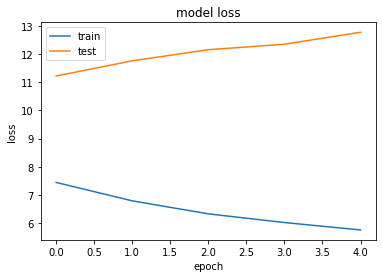

In [5]:
'''
Single Layer LSTM
'''
import numpy as np
import keras
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

WindowSizeTot = WindowSize*2 +1
ConvertedCorpus = np.array(ConvertedCorpus)# .reshape((1,WindowSize,len(ConvertedCorpus)))
ConvertedLabels = np.array(ConvertedLabels)

import tensorflow as tf

ConvertedCorpus = tf.cast(ConvertedCorpus, tf.float32)
ConvertedLabels = tf.cast(ConvertedLabels, tf.float32)

model = keras.Sequential(
    [
        keras.Input(shape=(WindowSizeTot, 256)),
        keras.layers.LSTM(128),
        # Bidirectional(LSTM(128)),
        keras.layers.Dense(410,activation="sigmoid"),
        Dropout(.2, input_shape=(2,)),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.000001)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=[tf.keras.metrics.Accuracy()]) #, metrics=['acc'])

history = model.fit(x=ConvertedCorpus, y=ConvertedLabels, validation_split=0.1, batch_size=128, epochs=5, shuffle=True).history

model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Epoch 1/5
267/267 [==============================] - 67s 235ms/step - loss: 7.2779 - accuracy: 0.1996 - val_loss: 12.5099 - val_accuracy: 0.0000e+00
Epoch 2/5
267/267 [==============================] - 58s 216ms/step - loss: 6.3564 - accuracy: 0.1995 - val_loss: 12.7628 - val_accuracy: 0.0000e+00
Epoch 3/5
267/267 [==============================] - 57s 212ms/step - loss: 5.8541 - accuracy: 0.1994 - val_loss: 13.1682 - val_accuracy: 0.0000e+00
Epoch 4/5
267/267 [==============================] - 56s 210ms/step - loss: 5.5981 - accuracy: 0.1995 - val_loss: 13.4465 - val_accuracy: 0.0000e+00
Epoch 5/5
267/267 [==============================] - 61s 228ms/step - loss: 5.4361 - accuracy: 0.1996 - val_loss: 13.9704 - val_accuracy: 0.0000e+00


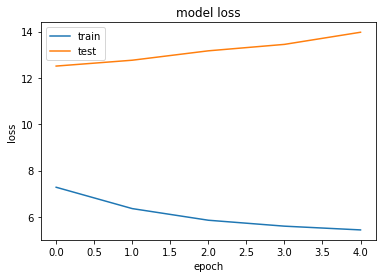

In [8]:
'''
1-layer BiLSTM
'''

WindowSizeTot = WindowSize*2 +1
ConvertedCorpus = np.array(ConvertedCorpus)# .reshape((1,WindowSize,len(ConvertedCorpus)))
ConvertedLabels = np.array(ConvertedLabels)

import tensorflow as tf

ConvertedCorpus = tf.cast(ConvertedCorpus, tf.float32)
ConvertedLabels = tf.cast(ConvertedLabels, tf.float32)

model = keras.Sequential(
    [
        keras.Input(shape=(WindowSizeTot, 256)),
        Bidirectional(LSTM(128)),
        keras.layers.Dense(410,activation="sigmoid"),
        Dropout(.2, input_shape=(2,)),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.000001)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=[tf.keras.metrics.Accuracy()]) #, metrics=['acc'])

history = model.fit(x=ConvertedCorpus, y=ConvertedLabels, validation_split=0.1, batch_size=128, epochs=5, shuffle=True).history

model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')